# Setup

In [1]:
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
PATH = "/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/"
import sys
from sklearn.model_selection import train_test_split
sys.path.append(PATH + "Final_version/1_0")
from utils import *
import xgboost
from pipelines import make_pipeline
from sklearn.linear_model import Ridge
from skopt.plots import plot_convergence
from skopt import forest_minimize
from tqdm import tqdm, trange
from models import *
import warnings
warnings.filterwarnings("ignore")

# Import Data

In [22]:
df = pd.read_csv(PATH + "datasets/train.csv")
test = pd.read_csv(PATH + "datasets/test.csv")
submission_sample = pd.read_csv(PATH + "datasets/submission_sample.csv")
metadata = pd.read_csv(PATH + "datasets/metadata.csv")
metadata.columns = ["cod", "type"]
 
num_dis = metadata[metadata.type == "Quantitativo discreto"].cod.to_list()
num_dis.remove("y")
num_con = metadata[metadata.type == "Quantitativo continua"].cod.to_list()
cat_nom = metadata[metadata.type == "Qualitativo nominal"].cod.to_list()
cat_nom.remove("id")
cat_ord = metadata[metadata.type == "Qualitativo ordinal"].cod.to_list() 
test_id = test["id"]
y = df["y"].to_numpy().astype(np.float32)
test.drop(["id"], axis=1, inplace=True)
df.drop(["id", "y"], axis=1, inplace=True)
create_path(PATH + "Final_version/1_0", list(range(1, 8)))

In [24]:
approach = 6
params = {
      "approach": approach,
      "num_dis": num_dis,
      "num_con": num_con,
      "cat_nom": cat_nom,
      "cat_ord": cat_ord
}
n_folders = 2
pipeline, list_remove = make_pipeline(params)
X = pd.concat([df, test])
if approach in [1,2,4,7]:
  X.drop(list_remove, axis=1, inplace=True)
if approach in [5,6]:
  list_remove, combined_columns_cat = list_remove
  for col in combined_columns_cat:
    X.loc[:, col] = X.loc[:, 'var1']

X_prepared = pipeline.fit_transform(X)
train_size = df.shape[0]
X_, test = X_prepared[:train_size, :], X_prepared[train_size:,:]
train, valid, y_train, y_valid = train_test_split(X_, y, test_size=0.4, random_state=42)
X_train0, X_train1, y_train0, y_train1 = train_test_split(train, y_train, test_size=0.4, random_state=42)

In [25]:
tm = TuneModels_(PATH + "Final_version/1_0", 6, (X_train0, y_train0), (X_train1, y_train1), (valid, y_valid), test)
tm.default_models()

Metrics -> xgb = 0.6506300114547539


In [30]:
save_y_id(PATH + "Final_version/1_0", 6, y_train1, y_valid, test_id)

In [16]:
class TuneModels_:
    def __init__(self, path, approach, train0, train1, valid, test):
        self.approach = approach
        self.X_train0, self.y_train0 = train0
        self.X_train1, self.y_train1 = train1
        self.valid, self.y_valid = valid
        self.test = test
        self.path = path

    def default_models(self):
        mdl = XGBClassifier(n_jobs=-1, random_state=42)
        mdl.fit(self.X_train0, self.y_train0)
        y_pred = mdl.predict_proba(self.X_train0)[:, 1]
        thrs, _ = better_threshold(self.y_train0, y_pred)

        y_pred = mdl.predict_proba(self.X_train1)[:, 1]
        model_name_train1 = self.path + "/preds_train1/approach{}/xgboost_default.pkl.z".format(self.approach)
        jb.dump(y_pred, model_name_train1)
            
        p = mdl.predict_proba(self.valid)[:,1]
        model_name_val1 = self.path + "/preds_val1/approach{}/xgboost_default.pkl.z".format(self.approach)
        jb.dump(p, model_name_val1)

        y_pred = (p >= thrs).astype(int)
        _, metric_xgb = evaluate(y_pred, self.y_valid, plot_matrix=False)

        p = mdl.predict_proba(self.test)[:,1]
        model_name_test = self.path + "/preds_test/approach{}/xgboost_default.pkl.z".format(self.approach)
        jb.dump(p, model_name_test)

        print(f"Metrics -> xgb = {metric_xgb}")

In [4]:
approach = 6
params = {
      "approach": approach,
      "num_dis": num_dis,
      "num_con": num_con,
      "cat_nom": cat_nom,
      "cat_ord": cat_ord
}
n_folders = 2
pipeline, list_remove = make_pipeline(params)
X = pd.concat([df, test])
if approach in [1,2,4,7]:
  X.drop(list_remove, axis=1, inplace=True)
if approach in [5,6]:
  list_remove, combined_columns_cat = list_remove
  for col in combined_columns_cat:
    X.loc[:, col] = X.loc[:, 'var1']

X_prepared = pipeline.fit_transform(X)
train_size = df.shape[0]
X_, test_ = X_prepared.tocsr()[:train_size, :], X_prepared.tocsr()[train_size:,:]
X_prepared = sparse.hstack((X_, y[:,None]))
X_prepared = gen_strat_folds(X_prepared, n_splits=3, isSparse=True)
train, valid = train_test_split(X_prepared, test_size=0.4, random_state=42)
X_train0, X_train1 = train_test_split(train, test_size=0.4, random_state=42)
save_y_id(PATH + "Final_version/1_0", approach, X_train1.tocsr()[:, -2].A, valid.tocsr()[:, -2].A, test_id)
tm = TuneModels(PATH + "Final_version/1_0", approach, (X_train0), (X_train1), (valid), test_, n_folders=3)
tm.default_models()

Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

Metrics -> lg = 0.4474456740842787 | lgbm = 0.658610810940885 | xgb = 0.6594160473186775 | rf = 0.46449636822513646


In [32]:
train_path, valid_path, test_path, approachs = return_params_level_2(PATH + "Final_version/1_0/")
train_dfs, valid_dfs, test_dfs = [], [], []
for approach in [6]:
  print()
  print(f"Approach {approach} começando ...")
  print("=====================================================================")
  paths = [train_path, valid_path, test_path]
  X_train, X_valid, X_test = return_dataframe(paths, approach)
  X_train, X_valid, X_test = add_y_and_id(paths, [X_train, X_valid, X_test], approach)
  X_train.to_csv("{}{}/train.csv".format(train_path, approach), index=False)
  X_valid.to_csv("{}{}/valid.csv".format(valid_path, approach), index=False)
  X_test.to_csv("{}{}/test.csv".format(test_path, approach), index=False)
  X_train, X_valid, X_test = read_dataframes(paths, approach)
  train_dfs.append(X_train)
  valid_dfs.append(X_valid)
  test_dfs.append(X_test)

X_train = pd.concat(train_dfs, axis=1)
X_valid = pd.concat(valid_dfs, axis=1)
X_test = pd.concat(test_dfs, axis=1)

name_ytrain1 = "{}{}/y.pkl.z".format(train_path, 6)
X_train['y'] = jb.load(name_ytrain1)
name_yvalid = "{}{}/y.pkl.z".format(valid_path, 6)
X_valid['y'] = jb.load(name_yvalid)
name_id = "{}{}/id.pkl.z".format(test_path, 6)
X_test['id'] = jb.load(name_id).astype(np.int)
X_train.to_csv("{}{}/train.csv".format(PATH,"Final_version/1_0/"), index=False)
X_valid.to_csv("{}{}/valid.csv".format(PATH,"Final_version/1_0/"), index=False)
X_test.to_csv("{}{}/test.csv".format(PATH,"Final_version/1_0/"), index=False)


Approach 6 começando ...


In [33]:
train = pd.read_csv("{}{}/train.csv".format(PATH,"Final_version/1_0/"))
valid = pd.read_csv("{}{}/valid.csv".format(PATH,"Final_version/1_0/"))
test = pd.read_csv("{}{}/test.csv".format(PATH,"Final_version/1_0/"))

In [45]:
ftr = "6/xgboost_default.pkl.z"
X_prepared = pd.concat([train, valid])
# X_prepared = gen_strat_folds(X_prepared, tgt_name="y", n_splits=3)

In [50]:
# list_thrs = []
# scores = []
# for fold in range(3):
#   train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
#   valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
#   X_train = train_data.drop(["y"], axis=1)
#   X_valid = valid_data.drop(["y"], axis=1)
#   y_train = train_data["y"].values
#   y_valid = valid_data["y"].values
#   Xtr = X_train[ftr].values 
#   Xval = X_valid[ftr].values 
#   thrs, _ = better_threshold(y_train, Xtr)
#   yval = (Xval >= thrs).astype(int)
#   scores.append(evaluate(yval, y_valid, plot_matrix=False)[1])
#   list_thrs.append(thrs)

Xtr = X_prepared[ftr].values 
thrs, _ = better_threshold(X_prepared["y"].to_numpy(), Xtr)
Xtest = test[ftr].copy()
preds = (Xtest >= thrs).astype(int)

In [51]:
preds.values

array([1, 0, 1, ..., 0, 0, 0])

In [52]:
pd.DataFrame({'id': test_id, 'predicted': preds}).to_csv(PATH + '/Submissions/Final_1_0_1_test3.csv', index=False)

# Stack level 1

In [ ]:
for approach in range(7, 8):
  print()
  print(f"Approach {approach} começando ...")
  print("=====================================================================")
  params = {
      "approach": approach,
      "num_dis": num_dis,
      "num_con": num_con,
      "cat_nom": cat_nom,
      "cat_ord": cat_ord
  }
  n_folders = 2
  pipeline, list_remove = make_pipeline(params)
  X = pd.concat([df, test])
  if approach in [1,2,4,7]:
    X.drop(list_remove, axis=1, inplace=True)
  if approach in [5,6]:
    list_remove, combined_columns_cat = list_remove
    for col in combined_columns_cat:
      X.loc[:, col] = X.loc[:, 'var1']
  X_prepared = pipeline.fit_transform(X)
  train_size = df.shape[0]
  X_, test_ = X_prepared.tocsr()[:train_size, :], X_prepared.tocsr()[train_size:,:]
  X_prepared = sparse.hstack((X_, y[:,None]))
  X_prepared = gen_strat_folds(X_prepared, n_splits=n_folders, isSparse=True)
  train, valid = train_test_split(X_prepared, test_size=0.4, random_state=42)
  X_train0, X_train1 = train_test_split(train, test_size=0.4, random_state=42)
  save_y_id(PATH + "Final_version/1_0", approach, X_train1.tocsr()[:, -2].A, valid.tocsr()[:, -2].A, test_id)
  tm = TuneModels(PATH + "Final_version/1_0", approach, X_train0, X_train1, valid, test_, n_folders=n_folders)
 
 
  #  space = [(200, 1000),
  #        (1, 1000),
  #        (100, 800),
  #        (1e-4, 1e-1, 'log-uniform')]
  # res_lgbm = forest_minimize(tm.tune_lgbm, space, base_estimator='RF', random_state=42, verbose=1, n_calls=30, n_random_starts=10)
  # plot_convergence(res_lgbm)
  # space = [
  #     (1e-3, 9e-1, 'log-uniform'),  # learning_rate
  #     (3, 30),  # max_depth
  #     (0.01, 20.0, 'log-uniform'),  # min_child_weight
  #     (0.2, 1.0),  # subsample
  #     (0.2, 1.0),  # colsample_bynode
  #     [1, 2, 3],  # num_parallel_tree
  #     (100, 1000)
  # ]
  #res_xg = forest_minimize(tm.tune_xgboost, space, base_estimator='RF', random_state=42, verbose=1, n_calls=30, n_random_starts=10)
  #plot_convergence(res_xg)
  # space = [(1e-8, 1e-6, 'log-uniform'),
  #         (100, 500),
  #         (1, 15)]
  # res_lr = forest_minimize(tm.tune_logistic, space, base_estimator='RF', random_state=42, verbose=1, n_calls=10, n_random_starts=10)
  # plot_convergence(res_lr)

  # space = [
  #     (1,32),  # n_neighbors
  #     (20, 41),  # leaf_size
  #     [1, 2],  # p
  #     ['uniform', 'distance'],  # weights
  #     ['minkowski'],  # metric
  # ]
  # res_knn = forest_minimize(tm.tune_knn, space, base_estimator='RF', random_state=42, verbose=1, n_calls=20, n_random_starts=10)
  # plot_convergence(res_knn)

  #  space = [(1, 30),
  #        (1.0, 5.5),
  #        (1, 30),
  #        (100, 1300)]

  # res_rf = forest_minimize(tm.tune_trees, space, base_estimator='RF', random_state=42, verbose=1, n_calls=30, n_random_starts=10)
  # plot_convergence(res_rf)

  # space = [(10, 600),
  #        (10, 600),
  #        (10, 60),
  #        (1e-5, 1e-3, 'log-uniform')]
                                      
  # res_nn = forest_minimize(tm.tune_nn, space, base_estimator='RF', random_state=42, verbose=1, n_calls=30, n_random_starts=10)
  # plot_convergence(res_nn)

  space = [(10, 600),
         (10, 600),
         (0.0, 0.95),
         (0.0, 0.95),
         (10, 60),
         (1e-5, 1e-3, 'log-uniform')]
  res_dropout = forest_minimize(tm.tune_nn_dropout, space, base_estimator='RF', random_state=42, verbose=1, n_calls=30, n_random_starts=10)
  plot_convergence(res_dropout)

# Stack level 2


## Make dataset level 2

In [ ]:
train_path, valid_path, test_path, approachs = return_params_level_2(PATH + "Final_version/1_0/")
train_dfs, valid_dfs, test_dfs = [], [], []
for approach in approachs:
  print()
  print(f"Approach {approach} começando ...")
  print("=====================================================================")
  paths = [train_path, valid_path, test_path]
  X_train, X_valid, X_test = return_dataframe(paths, approach)
  X_train, X_valid, X_test = add_y_and_id(paths, [X_train, X_valid, X_test], approach)
  X_train.to_csv("{}{}/train.csv".format(train_path, approach), index=False)
  X_valid.to_csv("{}{}/valid.csv".format(valid_path, approach), index=False)
  X_test.to_csv("{}{}/test.csv".format(test_path, approach), index=False)
  X_train, X_valid, X_test = read_dataframes(paths, approach)
  train_dfs.append(X_train)
  valid_dfs.append(X_valid)
  test_dfs.append(X_test)

X_train = pd.concat(train_dfs, axis=1)
X_valid = pd.concat(valid_dfs, axis=1)
X_test = pd.concat(test_dfs, axis=1)

name_ytrain1 = "{}{}/y.pkl.z".format(train_path, 1)
X_train['y'] = jb.load(name_ytrain1)
name_yvalid = "{}{}/y.pkl.z".format(valid_path, 1)
X_valid['y'] = jb.load(name_yvalid)
name_id = "{}{}/id.pkl.z".format(test_path, 1)
X_test['id'] = jb.load(name_id).astype(np.int)
X_train.to_csv("{}{}/train.csv".format(PATH,"Final_version/1_0/"), index=False)
X_valid.to_csv("{}{}/valid.csv".format(PATH,"Final_version/1_0/"), index=False)
X_test.to_csv("{}{}/test.csv".format(PATH,"Final_version/1_0/"), index=False)


Approach 1 começando ...

Approach 2 começando ...

Approach 3 começando ...

Approach 4 começando ...

Approach 5 começando ...

Approach 6 começando ...

Approach 7 começando ...


## Feature Selection

In [4]:
train = pd.read_csv("{}{}/train.csv".format(PATH,"Final_version/1_0/"))
valid = pd.read_csv("{}{}/valid.csv".format(PATH,"Final_version/1_0/"))
test = pd.read_csv("{}{}/test.csv".format(PATH,"Final_version/1_0/"))

## Test

In [7]:
ftr = "6/xgb_0.09224819202078124_5_0.17279520493131775_0.42769885738570945_0.7776601480281777_2_120.pkl.z"

In [5]:
X_prepared = pd.concat([train, valid])
X_prepared = gen_strat_folds(X_prepared, tgt_name="y", n_splits=3)

In [13]:
list_thrs = []
scores = []
for fold in range(3):
  train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
  valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
  X_train = train_data.drop(["y"], axis=1)
  X_valid = valid_data.drop(["y"], axis=1)
  y_train = train_data["y"].values
  y_valid = valid_data["y"].values
  Xtr = X_train[ftr].values 
  Xval = X_valid[ftr].values 
  thrs, _ = better_threshold(y_train, Xtr)
  yval = (Xval >= thrs).astype(int)
  scores.append(evaluate(yval, y_valid, plot_matrix=False)[1])
  list_thrs.append(thrs)
Xtest = test[ftr].copy()
preds = (Xtest >= np.mean(list_thrs)).astype(int)

In [15]:
np.mean(scores), scores

(0.6647953274343671, [0.65625, 0.668825910931174, 0.6693100713719271])

In [16]:
preds.values

array([1, 0, 1, ..., 0, 0, 0])

In [17]:
pd.DataFrame({'id': test_id, 'predicted': preds}).to_csv(PATH + '/Submissions/Final_1_0_1_test.csv', index=False)

In [ ]:
X_prepared = pd.concat([train, valid])
X_prepared = gen_strat_folds(X_prepared, tgt_name="y", n_splits=3)

In [ ]:
dist = np.array([0,0])

In [ ]:
selected_rg = ["6/xgb_0.09224819202078124_5_0.17279520493131775_0.42769885738570945_0.7776601480281777_2_120.pkl.z",
               "7/xgb_0.2255179693762968_17_2.60815836943177_0.6789267873576295_0.32481491235394927_1_430.pkl.z",
               "6/xgb_0.4856830940160751_6_0.03995460045412452_0.804289128254122_0.5401246995929958_1_871.pkl.z",
               "6/xgb_0.5856470892911934_3_0.17857085263501077_0.6194325998561582_0.9555715831012894_2_340.pkl.z",
               "4/lgbm_212_880_784_0.0016511818381995077.pkl.z",
               "5/nn_dropout_254_84_0.059438851274138844_0.7714383006862147_27_0.0008382687769460256.pkl.z",
               "6/nn_320_13_52_3.639053872051544e-05.pkl.z", # Não selecionado 0.6764405535581414
               "1/rf_20_5.278214378844623_11_1195.pkl.z", # 0.6766284932520157
               "1/rf_24_4.745991883601898_6_485.pkl.z", # 0.6766284932520157
               "1/nn_445_280_52_0.000362561763457623.pkl.z"] # 0.6766284932520157

In [ ]:
best_score = 0
for col in X_train.columns[:-1]:
  if col not in selected_rg:
    scores = []
    for fold in range(3):
      train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
      valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
      X_train = train_data.drop(["y"], axis=1)
      X_valid = valid_data.drop(["y"], axis=1)
      y_train = train_data.pop("y").to_numpy()
      y_valid = valid_data.pop("y").to_numpy()
      Xtr = X_train[selected_rg + [col]].copy()
      Xval = X_valid[selected_rg + [col]].copy()
      Xtr.columns = selected_rg + [col]
      Xval.columns = selected_rg + [col]
      mdl = Ridge(alpha=1.)
      mdl.fit(Xtr, y_train)
      p = mdl.predict(Xtr)
      thrs, _ = better_threshold(y_train, p)
      p = mdl.predict(Xval)
      y_pred = (p>= thrs).astype(int)
      scores.append(evaluate(y_pred, y_valid, plot_matrix=False)[1])

    c = np.mean(scores)
    if c > best_score:
      if c > dist.max() + 1e-4:
        print("Selected: ", col, c)
        print()
      else:
        print(col, c)
        print()
      best_score = c

1/lr_default.pkl.z 0.6725569216094419

1/lgbm_635_861_370_0.015702970884055385.pkl.z 0.6727196416899561

1/lgbm_508_770_443_0.0314288089084011.pkl.z 0.6731521277129581

1/lgbm_760_475_158_0.0015833718339012064.pkl.z 0.6742058488975017

1/lgbm_675_700_289_0.00018699039697141505.pkl.z 0.6762652523307825

1/rf_27_2.79937437271865_28_799.pkl.z 0.6764405535581414

1/rf_18_2.394761764037817_1_889.pkl.z 0.6764433421038083

1/nn_140_318_11_0.0002779697551526683.pkl.z 0.6766284932520157



In [ ]:
dist = []
for seed in range(100):
  scores = []
  for fold in range(3):
    train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
    valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
    X_train = train_data.drop(["y"], axis=1)
    X_valid = valid_data.drop(["y"], axis=1)
    y_train = train_data.pop("y").to_numpy()
    y_valid = valid_data.pop("y").to_numpy()
    Xtr = X_train[selected_rg].copy()
    Xval = X_valid[selected_rg].copy()
    Xtr.columns = selected_rg
    Xval.columns = selected_rg
    np.random.seed(seed)
    Xtr['random'] = np.random.permutation(Xtr.iloc[:, -1].values)
    Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)

    mdl = Ridge(alpha=1.)
    mdl.fit(Xtr, y_train)
    p = mdl.predict(Xtr)
    thrs, _ = better_threshold(y_train, p)
    p = mdl.predict(Xval)
    y_pred = (p>= thrs).astype(int)
    scores.append(evaluate(y_pred, y_valid, plot_matrix=False)[1])
  dist.append(np.mean(scores))

dist = np.array(dist)
dist.max() # 0.6766284932520157

0.6766284932520157

Iteration No: 1 started. Evaluating function at random point.
Testing parameters: [79.67464438733727, 0.0034826582042536028]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7058
Function value obtained: -0.6707
Current minimum: -0.6707
Iteration No: 2 started. Evaluating function at random point.
Testing parameters: [77.99113092724966, 0.05797491337166746]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4590
Function value obtained: -0.6707
Current minimum: -0.6707
Iteration No: 3 started. Evaluating function at random point.
Testing parameters: [44.63869201007377, 0.0019740136261996574]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3786
Function value obtained: -0.6703
Current minimum: -0.6707
Iteration No: 4 started. Evaluating function at random point.
Testing parameters: [45.978964307390136, 0.009679572227018539]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.5059
Function value obtained: -0.

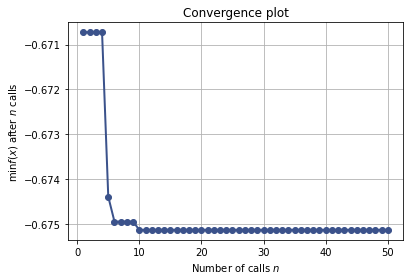

In [ ]:
def train_func(params):
    """ training funcion that will be optimised """
    alpha, tol = params
    print(f"Testing parameters: {params}")
    
    scores = []
    for fold in range(3):
        train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
        valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
        X_train = train_data.drop(["y"], axis=1)
        X_valid = valid_data.drop(["y"], axis=1)
        y_train = train_data["y"].values
        y_valid = valid_data["y"].values
        Xtr = X_train[selected_xg].values
        Xval = X_valid[selected_xg].values

        mdl = Ridge(alpha=alpha, tol=tol)
        mdl.fit(Xtr, y_train)
        p = mdl.predict(Xtr)
        thrs, _ = better_threshold(y_train, p)
        p = mdl.predict(Xval)
        y_pred = (p>= thrs).astype(int)
        scores.append(evaluate(y_pred, y_valid, plot_matrix=False)[1])
    f1_score = np.mean(scores)
    return -f1_score

space = [
    (0.1, 100),  # alpha
    (1e-3, 9e-1, 'log-uniform')  # tol
]

res_gp = forest_minimize(train_func, space, base_estimator='RF', random_state=42, verbose=1, n_calls=50, n_random_starts=10)
xgb_best_params = res_gp.x
print(f"Best found params: {xgb_best_params}") 
plot_convergence(res_gp)

In [ ]:
list_thrs = []
for fold in range(3):
        train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
        valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
        X_train = train_data.drop(["y"], axis=1)
        X_valid = valid_data.drop(["y"], axis=1)
        y_train = train_data["y"].values
        y_valid = valid_data["y"].values
        Xtr = X_train[selected_xg].values
        Xval = X_valid[selected_xg].values

        mdl = Ridge(alpha=1.0)
        mdl.fit(Xtr, y_train)
        p = mdl.predict(Xtr)
        thrs, _ = better_threshold(y_train, p)
        list_thrs.append(thrs)
Xtest = X_test[selected_rg].copy()
Xtr = X_prepared[selected_rg].copy()
y_train = X_prepared['y'].values
model = Ridge(alpha=1.0)
model.fit(Xtr, y_train)
p = model.predict(Xtest)
preds = (p >= np.mean(list_thrs)).astype(int)

In [ ]:
model = Ridge(alpha=1.0)
model.fit(Xtr, y_train)
model.predict(Xtest)
(p >= np.mean(list_thrs)).astype(int)

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
pd.DataFrame({'id': test_id, 'predicted': preds}).to_csv(PATH + '/Submissions/Final_1_0_1_rg.csv', index=False)

In [ ]:
X_train = pd.read_csv("{}{}/train.csv".format(PATH,"Final_version/1_0/"))
X_valid = pd.read_csv("{}{}/valid.csv".format(PATH,"Final_version/1_0/"))
X_test = pd.read_csv("{}{}/test.csv".format(PATH,"Final_version/1_0/"))

In [ ]:
X_prepared = pd.concat([X_train, X_valid])
X_prepared = gen_strat_folds(X_prepared, tgt_name="y", n_splits=3)

In [ ]:
y_train = X_train["y"].astype(np.float32)
y_valid = X_valid["y"].astype(np.float32)
test_id = X_test["id"]
X_train.drop(["y"], axis=1, inplace=True)
X_valid.drop(["y"], axis=1, inplace=True)
X_test.drop(["id"], axis=1, inplace=True)

In [ ]:
selected_xg = ["5/xgb_0.010248132938325605_6_0.013391269235929149_0.8227705154520741_0.2879988741967527_2_515.pkl.z",
               "7/xgb_0.1824958583181724_4_0.16771869687909102_0.8847936122437086_0.38898724402975116_3_764.pkl.z",
               "4/knn_5_38_1_uniform_minkowski.pkl.z",
               "3/xgb_0.008972080864147615_17_0.015723780972949804_0.7936261299150051_0.728570344838563_2_991.pkl.z",
               "5/knn_22_20_1_uniform_minkowski.pkl.z",  # 0.6595196249694064
               "6/xgb_0.09224819202078124_5_0.17279520493131775_0.42769885738570945_0.7776601480281777_2_120.pkl.z", # 0.6589588267364257
               "7/knn_22_20_1_uniform_minkowski.pkl.z",  # 0.6591199746882149
               "7/xgb_0.1426017637119142_3_0.011478065292873386_0.9796798337183934_0.36066105752092753_2_925.pkl.z", # 0.6586627966142719
               "3/xgb_0.008388618611685956_10_0.01117494233715713_0.8718747215071578_0.945066174466457_3_892.pkl.z", # 0.6615102605177748
               "2/knn_26_38_1_uniform_minkowski.pkl.z", # 0.6631659816250054
               "5/knn_24_31_2_uniform_minkowski.pkl.z"} # 0.6627036071883102

SyntaxError: ignored

In [ ]:
dist = np.array([0,0])

In [ ]:
best_score = 0
for col in tqdm(X_train.columns[:-1]):
  if col not in selected_xg:
    scores = []
    for fold in range(3):
      train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
      valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
      X_train = train_data.drop(["y"], axis=1)
      X_valid = valid_data.drop(["y"], axis=1)
      y_train = train_data.pop("y").to_numpy()
      y_valid = valid_data.pop("y").to_numpy()
      Xtr = X_train[selected_xg + [col]].copy()
      Xval = X_valid[selected_xg + [col]].copy()
      Xtr.columns = selected_xg + [col]
      Xval.columns = selected_xg + [col]
      model = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=42, colsample_bytree=0.1, subsample=0.25)
      model.fit(Xtr, y_train)
      p = model.predict_proba(Xtr)[:,1]
      thrs, _ = better_threshold(y_train, p)
      p = model.predict_proba(Xval)[:,1]
      y_pred = (p>= thrs).astype(int)
      scores.append(evaluate(y_pred, y_valid, plot_matrix=False)[1])

    c = np.mean(scores)
    if c > best_score:
      if c > dist.max():
        print()
        print("Selected: ", col, c)
        print()
      else:
        print()
        print(col, c)
        print()
      best_score = c

  0%|          | 1/868 [00:04<1:09:57,  4.84s/it]


1/lr_default.pkl.z 0.6590479824771186



  6%|▌         | 51/868 [04:03<1:04:52,  4.76s/it]


1/xgb_0.018167782016421892_11_0.012023438320285853_0.3331306697569775_0.9900008119661134_3_233.pkl.z 0.6597197548401238



 14%|█▍        | 125/868 [09:55<58:38,  4.74s/it]


1/nn_445_280_52_0.000362561763457623.pkl.z 0.6598791850692004



 22%|██▏       | 190/868 [15:04<53:27,  4.73s/it]


2/xgb_0.1340771960363294_4_0.041683013318981145_0.9330811149541434_0.47152331214578475_2_202.pkl.z 0.6598893874254487



 32%|███▏      | 278/868 [21:57<45:11,  4.60s/it]


2/knn_5_38_1_uniform_minkowski.pkl.z 0.660302534269118



 34%|███▎      | 291/868 [22:59<45:58,  4.78s/it]


3/lgbm_default.pkl.z 0.661122265421751



 34%|███▎      | 292/868 [23:04<45:56,  4.79s/it]


3/xgboost_default.pkl.z 0.661929913896977



 67%|██████▋   | 580/868 [45:40<21:18,  4.44s/it]


5/xgb_0.015422461050684438_3_0.43242076556579767_0.757398961093072_0.27245498156723164_1_987.pkl.z 0.661942859554522



 94%|█████████▍| 818/868 [1:04:07<03:31,  4.23s/it]


7/xgb_0.09168536554353601_13_0.02006570086727938_0.2801274128721919_0.8057410139727659_2_154.pkl.z 0.6621182275809455



 94%|█████████▍| 819/868 [1:04:12<03:34,  4.37s/it]


7/xgb_0.12234408026226168_14_0.01737064043841758_0.21519313714619692_0.651833426503179_3_197.pkl.z 0.6622967665120073



100%|██████████| 868/868 [1:08:00<00:00,  4.70s/it]


In [ ]:
dist = []
for seed in trange(50):
  scores = []
  for fold in range(3):
    train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
    valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
    X_train = train_data.drop(["y"], axis=1)
    X_valid = valid_data.drop(["y"], axis=1)
    y_train = train_data.pop("y").to_numpy()
    y_valid = valid_data.pop("y").to_numpy()
    Xtr = X_train[selected_xg].copy()
    Xval = X_valid[selected_xg].copy()
    Xtr.columns = selected_xg
    Xval.columns = selected_xg
    np.random.seed(seed)
    Xtr['random'] = np.random.permutation(Xtr.iloc[:, -1].values)
    Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)
 
    model = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=42, colsample_bytree=0.1, subsample=0.25)
    model.fit(Xtr, y_train)
    p = model.predict(Xtr)
    thrs, _ = better_threshold(y_train, p)
    p = model.predict(Xval)
    y_pred = (p>= thrs).astype(int)
    scores.append(evaluate(y_pred, y_valid, plot_matrix=False)[1])

  dist.append(np.mean(scores))
 
dist = np.array(dist)
dist.max()

100%|██████████| 50/50 [03:59<00:00,  4.79s/it]


0.662329353777248

## Train Model level 2

In [ ]:
selected_xg = ["5/xgb_0.010248132938325605_6_0.013391269235929149_0.8227705154520741_0.2879988741967527_2_515.pkl.z",
               "7/xgb_0.1824958583181724_4_0.16771869687909102_0.8847936122437086_0.38898724402975116_3_764.pkl.z",
               "4/knn_5_38_1_uniform_minkowski.pkl.z",
               "3/xgb_0.008972080864147615_17_0.015723780972949804_0.7936261299150051_0.728570344838563_2_991.pkl.z"]
selected_xg = selected_rg

In [ ]:
X_prepared = pd.concat([X_train, X_valid])
X_prepared = gen_strat_folds(X_prepared, tgt_name="y", n_splits=5)

In [ ]:
scores = []
xgb = XGBClassifier(
        n_jobs=-1,
        eval_metric='auc',
        random_state=0,
    )

for fold in range(3):
    train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
    valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
    X_train = train_data.drop(["y"], axis=1)
    X_valid = valid_data.drop(["y"], axis=1)
    y_train = train_data["y"].values
    y_valid = valid_data["y"].values
    Xtr = X_train[selected_xg].values
    Xval = X_valid[selected_xg].values

    fit_params = {
        'early_stopping_rounds': 100,
        'eval_metric' : 'auc',
        'eval_set' : [(Xval, y_valid)],
        'verbose': False,
    }

    xgb.fit(Xtr, y_train, **fit_params)
    p = xgb.predict_proba(Xtr)[:,1]
    thrs, _ = better_threshold(y_train, p)
    p = xgb.predict_proba(Xval)[:,1]
    y_pred = (p>= thrs).astype(int)
    scores.append(evaluate(y_pred, y_valid, plot_matrix=False)[1])
    
f1_score = np.mean(scores)
print(f"Baseline f1 = {round(f1_score, 4)}")

Baseline f1 = 0.6723


Iteration No: 1 started. Evaluating function at random point.
Testing parameters: [0.2255179693762968, 17, 2.60815836943177, 0.6789267873576295, 0.32481491235394927, 1, 430]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.1604
Function value obtained: -0.6475
Current minimum: -0.6475
Iteration No: 2 started. Evaluating function at random point.
Testing parameters: [0.02273697053907668, 23, 0.9644921218755025, 0.7664580622368364, 0.21646759543664196, 3, 905]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.2874
Function value obtained: -0.6565
Current minimum: -0.6565
Iteration No: 3 started. Evaluating function at random point.
Testing parameters: [0.0010053115290973656, 30, 0.04031102009377834, 0.44339379436763027, 0.6198051453057903, 2, 574]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.5615
Function value obtained: -0.6551
Current minimum: -0.6565
Iteration No: 4 started. Evaluating function at random point.
Testing

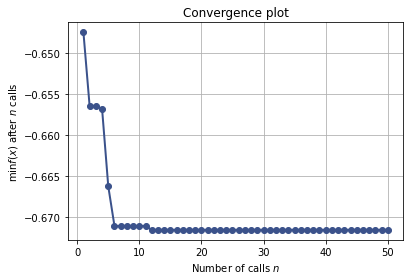

In [ ]:
def train_func(params):
    """ training funcion that will be optimised """
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight=params[2]
    subsample = params[3]
    colsample_bynode = params[4]
    num_parallel_tree = params[5]
    n_estimators = params[6]
    print(f"Testing parameters: {params}")
    
    scores = []
    for fold in range(3):
        train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
        valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
        X_train = train_data.drop(["y"], axis=1)
        X_valid = valid_data.drop(["y"], axis=1)
        y_train = train_data["y"].values
        y_valid = valid_data["y"].values
        Xtr = X_train[selected_xg].values
        Xval = X_valid[selected_xg].values

        
        fit_params = {
            'early_stopping_rounds': 100,
            'eval_metric' : 'auc',
            'eval_set': [(Xval, y_valid)],
            'verbose': False,
        }

        xgb = XGBClassifier(
            n_jobs=-1,
            eval_metric='auc',
            random_state=42,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bynode=colsample_bynode,
            num_parallel_tree=num_parallel_tree
        )
        
        xgb.fit(Xtr, y_train, **fit_params)
        p = xgb.predict_proba(Xtr)[:,1]
        thrs, _ = better_threshold(y_train, p)
        p = xgb.predict_proba(Xval)[:,1]
        y_pred = (p>= thrs).astype(int)
        scores.append(evaluate(y_pred, y_valid, plot_matrix=False)[1])
    f1_score = np.mean(scores)
    return -f1_score

space = [
    (1e-3, 9e-1, 'log-uniform'),  # learning_rate
    (3, 30),  # max_depth
    (0.01, 20.0, 'log-uniform'),  # min_child_weight
    (0.2, 1.0),  # subsample
    (0.2, 1.0),  # colsample_bynode
    [1, 2, 3],  # num_parallel_tree
    (100, 1300)
]

res_gp = forest_minimize(train_func, space, base_estimator='RF', random_state=42, verbose=1, n_calls=50, n_random_starts=10)
xgb_best_params = res_gp.x
print(f"Best found params: {xgb_best_params}") 
plot_convergence(res_gp)

* Best parameters 100 estimators: Best found params: [0.26564292427597624, 3, 1.7564156925509018, 0.6189767530537726, 0.8530666337598767, 3] -> 0.6725

* Best parameters n estimators: [0.0021188773383812097, 29, 19.496507317770742, 0.3912305426503594, 0.5193981136010135, 1, 1014] -> 0.6716

* Best parameters 1000 estimators: [0.05895242175965249, 16, 17.63528032943269, 0.26249817427216754, 0.9192611525403462, 1] -> 0.6718

In [ ]:
def xgb_learning_rate_decay_power_099(boosting_round, num_boost_round):
    base_learning_rate = xgb_best_params[0]
    lr = base_learning_rate  * np.power(.99, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_decay_power_0995(boosting_round, num_boost_round):
    base_learning_rate = xgb_best_params[0]
    lr = base_learning_rate  * np.power(.995, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_decay_power_095(boosting_round, num_boost_round):
    base_learning_rate = xgb_best_params[0]
    lr = base_learning_rate  * np.power(.95, boosting_round)
    return lr if lr > 1e-3 else 1e-3

# testing some default values
def xgb_learning_rate_010_decay_power_099(boosting_round, num_boost_round):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_010_decay_power_0995(boosting_round, num_boost_round):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_010_decay_power_095(boosting_round, num_boost_round):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.95, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_050_decay_power_099(boosting_round, num_boost_round):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_050_decay_power_0995(boosting_round, num_boost_round):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.995, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_050_decay_power_095(boosting_round, num_boost_round):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.95, boosting_round)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
poss_cbs = {
    0: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_099)],
    1: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_0995)],
    2: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_095)],
    3: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_099)],
    4: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_0995)],
    5: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_095)],
    6: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_099)],
    7: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_0995)],
    8: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_095)]
}
xgb_best_params = [0.26564292427597624, 3, 1.7564156925509018, 0.6189767530537726, 0.8530666337598767, 3]
learning_rate = xgb_best_params[0]
max_depth = xgb_best_params[1]
min_child_weight = xgb_best_params[2]
subsample = xgb_best_params[3]
colsample_bynode = xgb_best_params[4]
num_parallel_tree = xgb_best_params[5]

# trying different lr decay callbacks
best_cb = None
best_score = 0
for cb in poss_cbs:
    scores = []
    for fold in tqdm_notebook(range(3), desc="Cross validation progress"):
        train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
        valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
        X_train = train_data.drop(["y"], axis=1)
        X_valid = valid_data.drop(["y"], axis=1)
        y_train = train_data["y"].values
        y_valid = valid_data["y"].values
        Xtr = X_train[selected_xg].values
        Xval = X_valid[selected_xg].values

        fit_params = {
            'early_stopping_rounds': 1000,
            'eval_metric' : 'auc',
            'eval_set': [(Xval, y_valid)],
            'callbacks': poss_cbs[cb],
            'verbose': False,
        }

        xgb = XGBClassifier(
            n_jobs=-1,
            eval_metric='auc',
            random_state=0,
            n_estimators=100,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bynode=colsample_bynode,
            num_parallel_tree=num_parallel_tree
        )

        xgb.fit(Xtr, y_train, **fit_params)
        p = xgb.predict_proba(Xtr)[:,1]
        thrs, _ = better_threshold(y_train, p)
        p = xgb.predict_proba(Xval)[:,1]
        y_pred = (p>= thrs).astype(int)
        scores.append(evaluate(y_pred, y_valid, plot_matrix=False)[1])

    f1_score = np.mean(scores)
    print(f"Callback: {cb}, f1 = {round(f1_score, 4)}")
    if f1_score > best_score:
        best_score = f1_score
        best_cb = cb

Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

Callback: 0, f1 = 0.6701


Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

Callback: 1, f1 = 0.6654


Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

Callback: 2, f1 = 0.6691


Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

Callback: 3, f1 = 0.6706


Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

Callback: 4, f1 = 0.6721


Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

Callback: 5, f1 = 0.6702


Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

Callback: 6, f1 = 0.6731


Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

Callback: 7, f1 = 0.6731


Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

Callback: 8, f1 = 0.6679


In [ ]:
best_cb

6

In [ ]:
cross_val_probas = []
ground_truths = []
for fold in tqdm_notebook(range(3), desc="Cross validation progress"):
    train_data = X_prepared[X_prepared.fold != fold].drop(["fold"], axis=1)
    valid_data = X_prepared[X_prepared.fold == fold].drop(["fold"], axis=1)
    X_train = train_data.drop(["y"], axis=1)
    X_valid = valid_data.drop(["y"], axis=1)
    y_train = train_data["y"].values
    y_valid = valid_data["y"].values
    Xtr = X_train[selected_xg].values
    Xval = X_valid[selected_xg].values

    fit_params = {
        'early_stopping_rounds': 1000,
        'eval_metric' : 'auc',
        'eval_set': [(Xval, y_valid)],
        'callbacks': poss_cbs[best_cb],
        'verbose': False,
    }

    xgb = XGBClassifier(
        n_jobs=-1,
        eval_metric='auc',
        random_state=0,
        n_estimators=100,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bynode=colsample_bynode,
        num_parallel_tree=num_parallel_tree
    )

    xgb.fit(Xtr, y_train, **fit_params)
    p = xgb.predict_proba(Xval)[:, -1]
    cross_val_probas += p.tolist()
    ground_truths += y_valid.tolist()

Cross validation progress:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
best_th, f1_max = better_threshold(ground_truths, cross_val_probas)
print(f"MAX F1 SCORE: {f1_max}, THRESHHOLD: {best_th}")

MAX F1 SCORE: 0.6733780760626398, THRESHHOLD: 0.40863969922065735


In [ ]:
poss_cbs = {
    0: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_099)],
    1: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_0995)],
    2: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_095)],
    3: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_099)],
    4: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_0995)],
    5: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_095)],
    6: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_099)],
    7: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_0995)],
    8: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_095)]
}
Xtest = X_test[selected_xg].copy()
Xtr = X_prepared[selected_xg].copy()
y_train = X_prepared['y'].values

fit_params = {
    'eval_metric' : 'auc',
    'callbacks': poss_cbs[best_cb],
    'verbose': False,
}
xgb = XGBClassifier(
    n_jobs=-1,
    eval_metric='auc',
    random_state=42,
    n_estimators=100,
    learning_rate=learning_rate,
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    subsample=subsample,
    colsample_bynode=colsample_bynode,
    num_parallel_tree=num_parallel_tree
)

xgb.fit(Xtr, y_train, **fit_params)
p = xgb.predict_proba(Xtest)[:, 1]
preds = (p >= best_th).astype(int)

In [ ]:
preds

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
pd.DataFrame({'id': test_id, 'predicted': preds}).to_csv(PATH + '/Submissions/Final_1_0_1_xg.csv', index=False)